In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shap
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression

## Data Preprocessing

In [68]:
df = pd.read_csv('/kaggle/input/breast-cancer-dataset/breast-cancer.csv', index_col=0)

In [69]:
df = df.rename(columns={'concave points_mean': 'concave_points_mean'})
df = df.rename(columns={'concave points_worst': 'concave_points_worst'})

In [70]:
df.shape

(569, 31)

In [71]:
df.head() # all feature are numeric and continuous

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [72]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [73]:
x = df.drop(columns=['diagnosis'])
y = df['diagnosis']=='M' # 1 if malignant, 0 else

In [74]:
standard_scaler = StandardScaler()
x_np = standard_scaler.fit_transform(x)
x = pd.DataFrame(x_np, columns=x.columns, index=x.index)
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-1.373633e-16,6.868164e-17,-1.248757e-16,-2.185325e-16,-8.366672e-16,1.873136e-16,4.995028e-17,-4.995028e-17,1.748260e-16,4.745277e-16,...,-8.241796e-16,1.248757e-17,-3.746271e-16,0.000000,-2.372638e-16,-3.371644e-16,7.492542e-17,2.247763e-16,2.622390e-16,-5.744282e-16
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-0.642136,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-0.341181,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,0.357589,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


In [75]:
x.isnull().sum().sum() # 0 NaN values

0

In [76]:
# split in 70-15-15
x_train, x_b, y_train, y_b = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=22)
x_val, x_test, y_val, y_test = train_test_split(x_b, y_b, train_size=0.5, test_size=0.5, random_state=22)

## Visualize Data

### Histograms

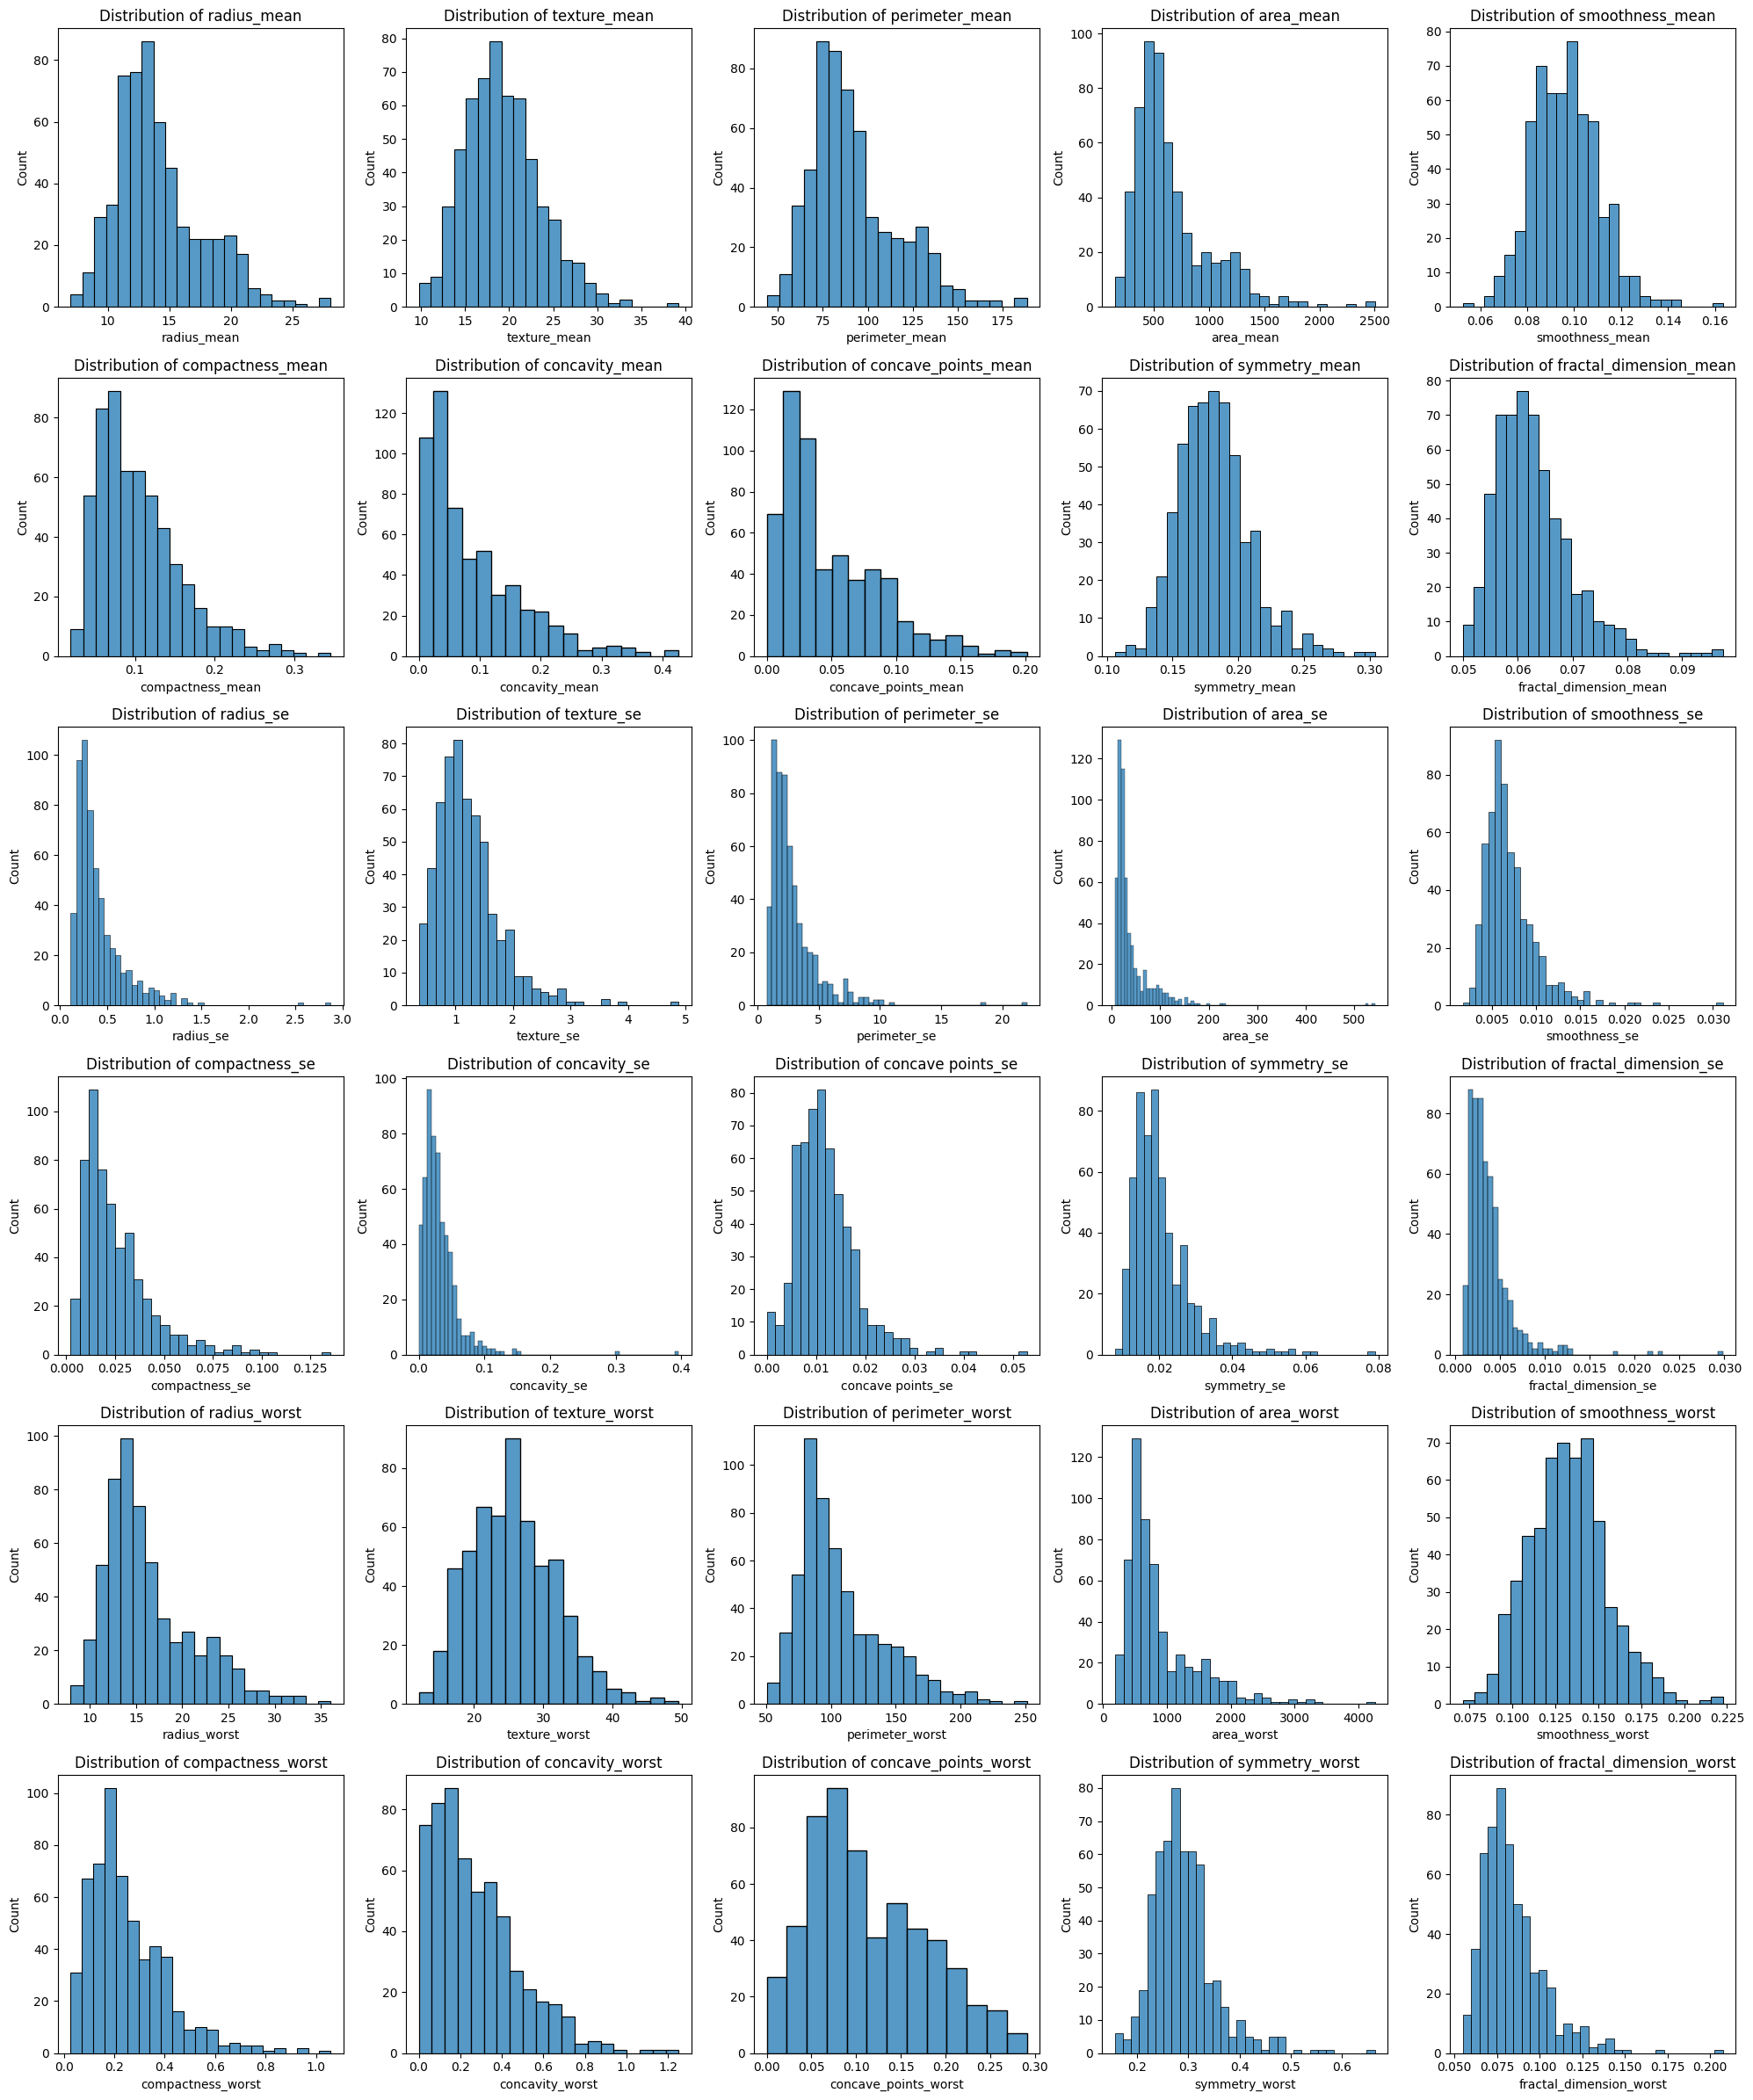

In [77]:
features = x.columns
import warnings
warnings.filterwarnings('ignore')

# rows and columns for plot
n_features = len(features)
n_cols = 5
n_rows = n_features // n_cols + (n_features % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# plot each feature
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

for i in range(n_features, len(axes)): fig.delaxes(axes[i]) # remove empty subplots

plt.tight_layout()
plt.show()

### Other Plots

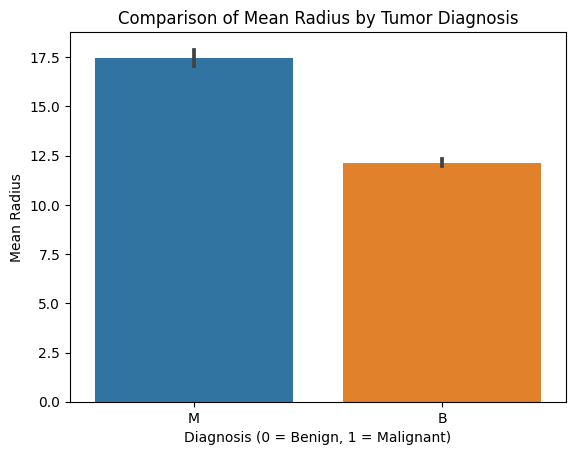

In [78]:
sns.barplot(x=df['diagnosis'], y=df['radius_mean'])

# Set plot labels and title
plt.xlabel('Diagnosis (0 = Benign, 1 = Malignant)')
plt.ylabel('Mean Radius')
plt.title('Comparison of Mean Radius by Tumor Diagnosis')
plt.show()

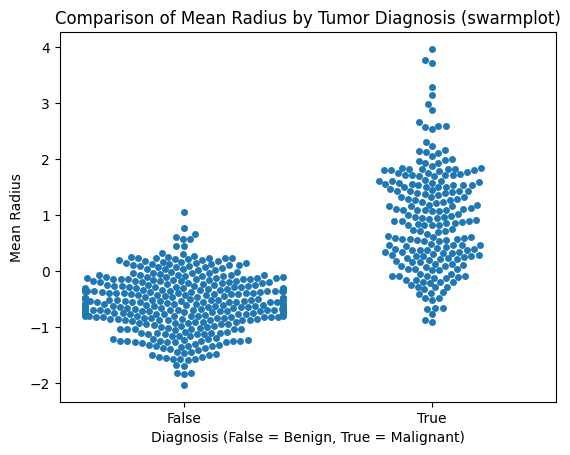

In [79]:
sns.swarmplot(x=y,y=x.radius_mean)

# Set plot labels and title
plt.xlabel('Diagnosis (False = Benign, True = Malignant)')
plt.ylabel('Mean Radius')
plt.title('Comparison of Mean Radius by Tumor Diagnosis (swarmplot)')
plt.show()

### Heatmap + Best (Linear) Correlations

<Axes: >

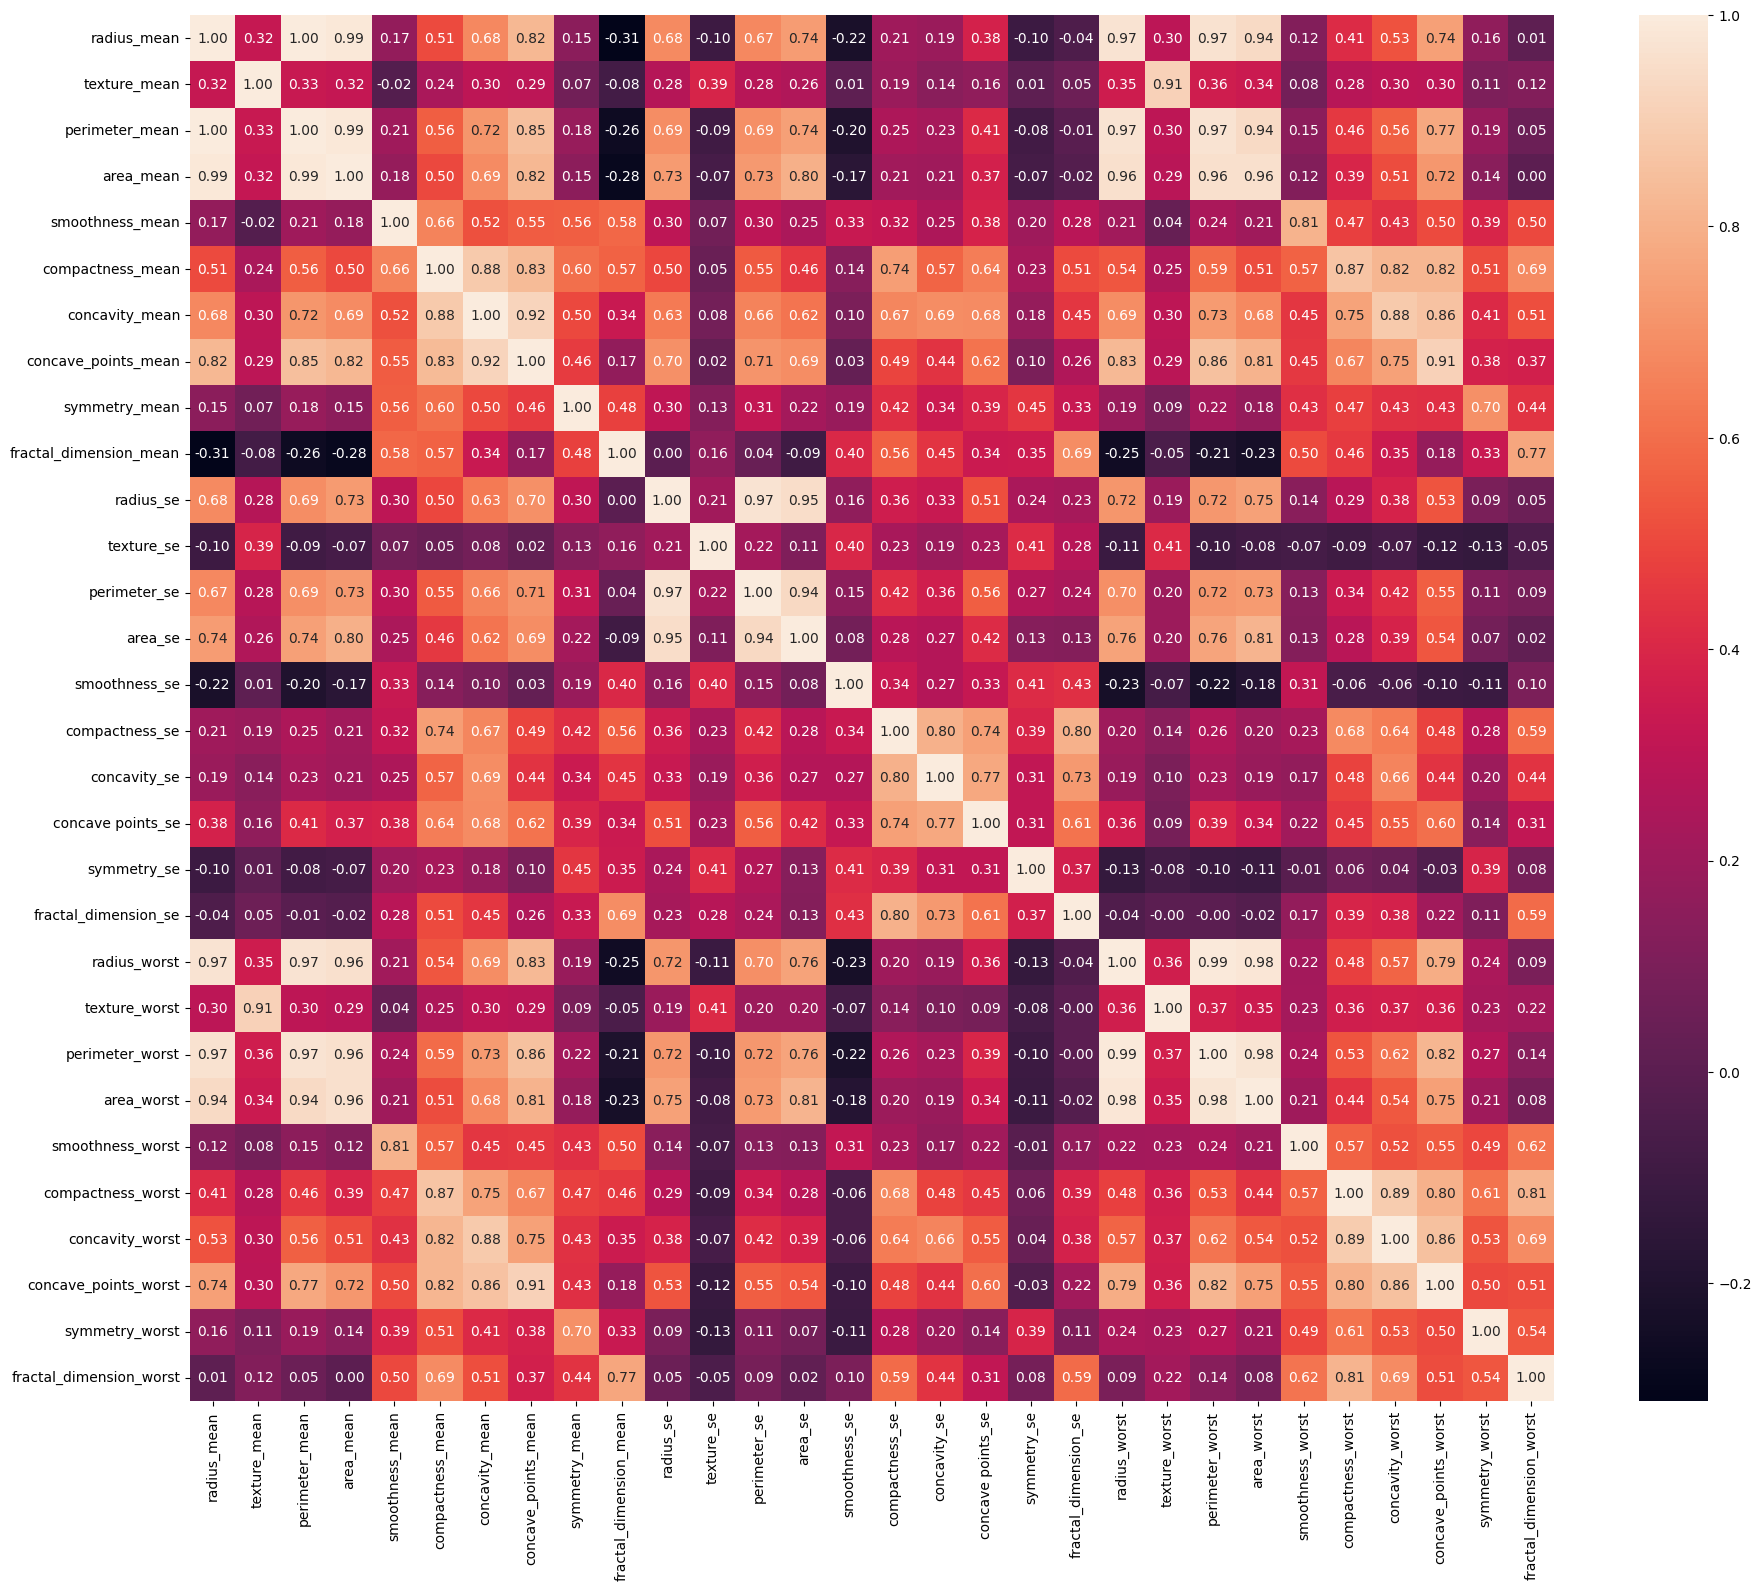

In [80]:
plt.figure(figsize=(22,18))
sns.heatmap(data=x.corr(), fmt = '0.2f', annot=True)

In [81]:
corr_pairs = x.corr().unstack()
corr_pairs = corr_pairs[corr_pairs < 1] # remove self-correlations
sorted_pairs = corr_pairs.abs().sort_values(ascending=False)

# Display the top 20 correlations
top_20_corr = sorted_pairs.head(20)
print(top_20_corr)

perimeter_mean   radius_mean        0.997855
radius_mean      perimeter_mean     0.997855
perimeter_worst  radius_worst       0.993708
radius_worst     perimeter_worst    0.993708
radius_mean      area_mean          0.987357
area_mean        radius_mean        0.987357
                 perimeter_mean     0.986507
perimeter_mean   area_mean          0.986507
radius_worst     area_worst         0.984015
area_worst       radius_worst       0.984015
perimeter_worst  area_worst         0.977578
area_worst       perimeter_worst    0.977578
perimeter_se     radius_se          0.972794
radius_se        perimeter_se       0.972794
perimeter_worst  perimeter_mean     0.970387
perimeter_mean   perimeter_worst    0.970387
radius_worst     radius_mean        0.969539
radius_mean      radius_worst       0.969539
perimeter_mean   radius_worst       0.969476
radius_worst     perimeter_mean     0.969476
dtype: float64


### Scatter and Regression Plots

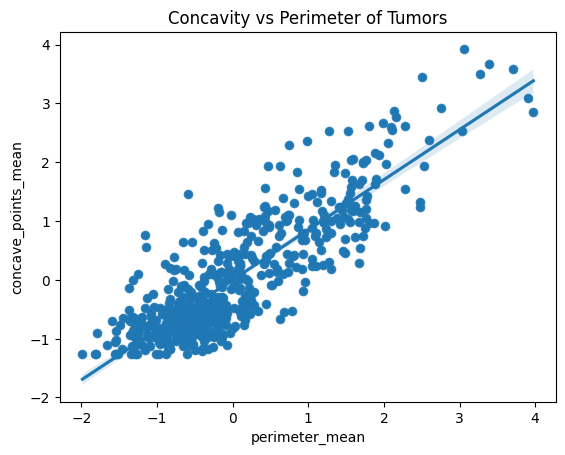

In [82]:
# an example of a non banale correlation
sns.scatterplot(x=x.perimeter_mean,y=x.concave_points_mean)
sns.regplot(x=x.perimeter_mean,y=x.concave_points_mean)

plt.title('Concavity vs Perimeter of Tumors')
plt.show()

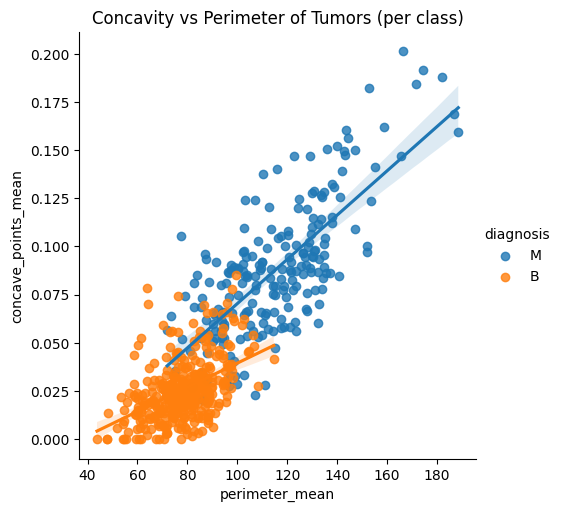

In [83]:
sns.lmplot(x='perimeter_mean',y='concave_points_mean',hue='diagnosis',data=df) 

plt.title('Concavity vs Perimeter of Tumors (per class)')
plt.show()

## Models

### Decision Tree Classifier

In [84]:
def tree_model(max_leaf_nodes, x_train, y_train, x_val, y_val):
    model = DecisionTreeClassifier(random_state=22, max_leaf_nodes=max_leaf_nodes)
    model.fit(x_train,y_train) # sul training
    pred_val = model.predict(x_val) # sul validation
    accuracy = accuracy_score(y_val, pred_val)
    print(f"max_leaf_nodes: {max_leaf_nodes}, Validation Accuracy: {accuracy:.5f}")

In [85]:
max_leaf_nodes = [5,10,50,100,200,500]
for leaf in max_leaf_nodes:
    tree_model(leaf, x_train, y_train, x_val, y_val)

max_leaf_nodes: 5, Validation Accuracy: 0.94118
max_leaf_nodes: 10, Validation Accuracy: 0.92941
max_leaf_nodes: 50, Validation Accuracy: 0.91765
max_leaf_nodes: 100, Validation Accuracy: 0.91765
max_leaf_nodes: 200, Validation Accuracy: 0.91765
max_leaf_nodes: 500, Validation Accuracy: 0.91765


In [86]:
model_tree = DecisionTreeClassifier(random_state=22, max_leaf_nodes=5)
model_tree.fit(x_train,y_train) # sul training
pred_val = model_tree.predict(x_val) # sul validation
accuracy = accuracy_score(y_val, pred_val)
print(f"max_leaf_nodes: {5}, Validation Accuracy: {accuracy:.5f}")

max_leaf_nodes: 5, Validation Accuracy: 0.94118


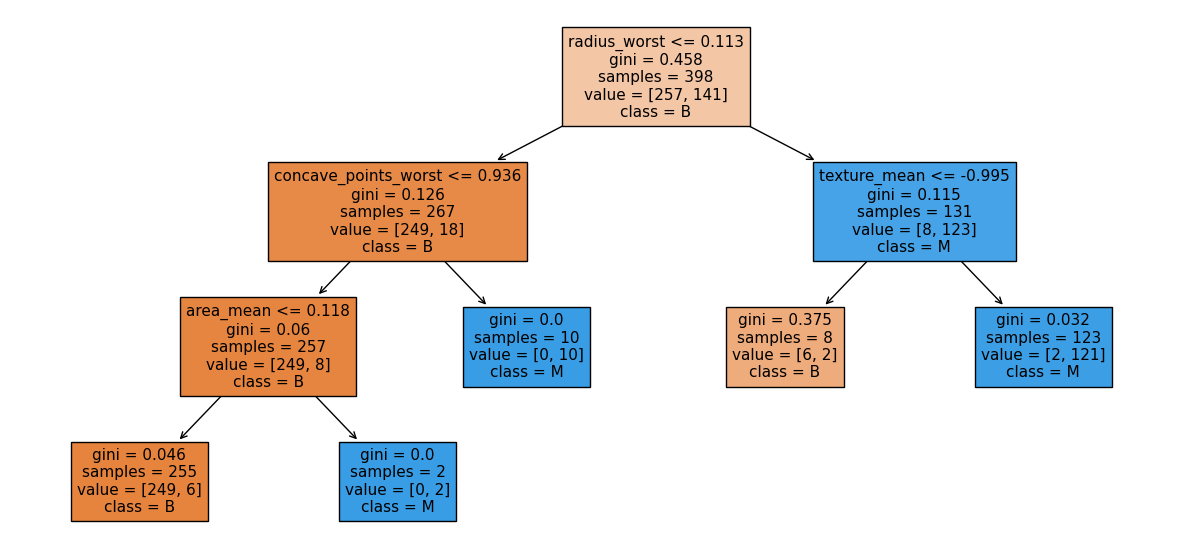

In [87]:
plt.figure(figsize=(15,7))

plot_tree(model_tree, 
          filled=True, 
          feature_names=list(x_train.columns), 
          class_names=['B', 'M'])

plt.show()

### Random Forest Classifier

In [88]:
def forest_model(max_leaf_nodes, n_estimators, x_train, y_train, x_val, y_val):
    model = RandomForestClassifier(random_state=22, max_leaf_nodes=max_leaf_nodes, n_estimators=n_estimators)
    model.fit(x_train,y_train) # sul training
    pred_val = model.predict(x_val) # sul validation
    accuracy = accuracy_score(y_val, pred_val)
    print(f"max_leaf_nodes: {max_leaf_nodes}, n_estimators: {n_estimators}, Validation Accuracy: {accuracy:.5f}")

In [89]:
max_leaf_nodes = [5,10,50,100,200,500]
n_estimators = [5,10,50,100,200,500]
for i in max_leaf_nodes:
    for j in n_estimators:
        forest_model(i, j, x_train, y_train, x_val, y_val)

max_leaf_nodes: 5, n_estimators: 5, Validation Accuracy: 0.92941
max_leaf_nodes: 5, n_estimators: 10, Validation Accuracy: 0.94118
max_leaf_nodes: 5, n_estimators: 50, Validation Accuracy: 0.94118
max_leaf_nodes: 5, n_estimators: 100, Validation Accuracy: 0.94118
max_leaf_nodes: 5, n_estimators: 200, Validation Accuracy: 0.94118
max_leaf_nodes: 5, n_estimators: 500, Validation Accuracy: 0.94118
max_leaf_nodes: 10, n_estimators: 5, Validation Accuracy: 0.96471
max_leaf_nodes: 10, n_estimators: 10, Validation Accuracy: 0.95294
max_leaf_nodes: 10, n_estimators: 50, Validation Accuracy: 0.94118
max_leaf_nodes: 10, n_estimators: 100, Validation Accuracy: 0.92941
max_leaf_nodes: 10, n_estimators: 200, Validation Accuracy: 0.94118
max_leaf_nodes: 10, n_estimators: 500, Validation Accuracy: 0.94118
max_leaf_nodes: 50, n_estimators: 5, Validation Accuracy: 0.96471
max_leaf_nodes: 50, n_estimators: 10, Validation Accuracy: 0.94118
max_leaf_nodes: 50, n_estimators: 50, Validation Accuracy: 0.9411

In [90]:
model_forest = RandomForestClassifier(random_state=22, max_leaf_nodes=10, n_estimators=5)
model_forest.fit(x_train,y_train) # sul training
pred_forest = model_forest.predict(x_val) # sul validation
accuracy = accuracy_score(y_val, pred_forest)
print(f"max_leaf_nodes: 10, n_estimators: 5, Validation Accuracy: {accuracy:.5f}")

max_leaf_nodes: 10, n_estimators: 5, Validation Accuracy: 0.96471


### XGBoost Classifier

In [91]:
model_xgb_best = XGBClassifier(random_state=22, learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=4)
model_xgb_best.fit(x_train,y_train) # sul training
pred_val_xgb = model_xgb_best.predict(x_val) # sul validation
accuracy = accuracy_score(y_val, pred_val_xgb)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9411764705882353


### SVM

In [92]:
def svm_model(C, gamma, kernel, x_train, y_train, x_val, y_val):
    model = SVC(random_state=22, C=C, gamma=gamma, kernel=kernel)
    model.fit(x_train,y_train) # sul training
    pred_val = model.predict(x_val) # sul validation
    accuracy = accuracy_score(y_val, pred_val)
    print(f"C: {C}, gamma: {gamma}, kernel: {kernel}, Validation Accuracy: {accuracy:.5f}")

In [93]:
model_svm = SVC(random_state=22, C=0.1, gamma='scale', kernel='linear')
model_svm.fit(x_train,y_train) # sul training
pred_val_svm = model_svm.predict(x_val) # sul validation
accuracy = accuracy_score(y_val, pred_val_svm)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9529411764705882


### Neural Network

In [94]:
# Define the neural network model
model_nn = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [95]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.001, 
    restore_best_weights=True
)

In [96]:
history = model_nn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - binary_accuracy: 0.3908 - loss: 0.7312 - val_binary_accuracy: 0.8824 - val_loss: 0.5812
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.8366 - loss: 0.5772 - val_binary_accuracy: 0.8706 - val_loss: 0.4825
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.9403 - loss: 0.4618 - val_binary_accuracy: 0.8706 - val_loss: 0.4065
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.9533 - loss: 0.3733 - val_binary_accuracy: 0.8706 - val_loss: 0.3452
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.9546 - loss: 0.2986 - val_binary_accuracy: 0.8824 - val_loss: 0.2998
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.9594 - loss: 0.2331 - val_binary_accuracy: 0.9059 - val_loss: 0.2690
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.9529 - loss: 0.1891 - val_binary_accuracy: 0.9059 - val_loss: 0.2504
Epoch 8/100
2/2 ━━━

## Feature Importance

perimeter_worst         0.473387
area_worst              0.463288
radius_worst            0.456947
concave_points_worst    0.436209
concave_points_mean     0.436061
perimeter_mean          0.402936
concavity_mean          0.374445
radius_mean             0.361199
area_mean               0.359468
area_se                 0.337170
concavity_worst         0.316896
perimeter_se            0.275971
radius_se               0.245417
compactness_worst       0.226367
compactness_mean        0.216178
concave points_se       0.128089
texture_worst           0.118904
concavity_se            0.109104
smoothness_worst        0.098967
texture_mean            0.094937
Name: MI Scores, dtype: float64


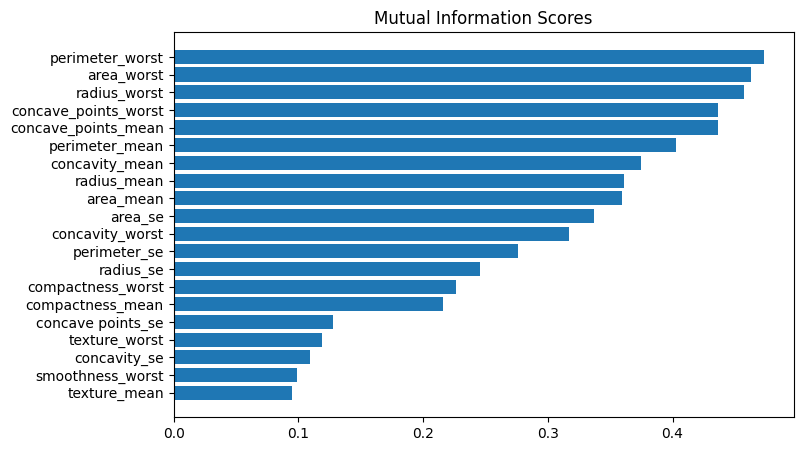

In [97]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = make_mi_scores(x, y)
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [98]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

log_odds = 3.75
probability = sigmoid(log_odds)
print(f"Probability of tumor being malignant: {probability:.4f}")

Probability of tumor being malignant: 0.9770


## Test Set Results

In [99]:
pred_tree = model_tree.predict(x_test)
accuracy_tree = accuracy_score(y_test, pred_tree)
print(f"Test Accuracy: {accuracy_tree:.5f}")

Test Accuracy: 0.86047


In [100]:
pred_forest = model_forest.predict(x_test)
accuracy_forest = accuracy_score(y_test, pred_forest)
print(f"Test Accuracy: {accuracy_forest:.5f}")

Test Accuracy: 0.94186


In [101]:
pred_xgb = model_xgb_best.predict(x_test)
accuracy_xgb = accuracy_score(y_test, pred_xgb)
print(f"Test Accuracy: {accuracy_xgb:.5f}")

Test Accuracy: 0.94186


In [102]:
pred_svm = model_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, pred_svm)
print(f"Test Accuracy: {accuracy_svm:.5f}")

Test Accuracy: 0.97674


In [103]:
_, accuracy_nn = model_nn.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy_nn:.5f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 1.0000 - loss: 0.0522 
Test Accuracy: 1.00000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


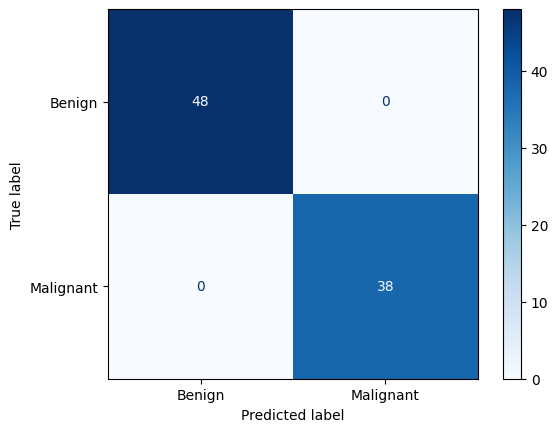

In [104]:
# Predict on test data
y_test_pred = model_nn.predict(x_test)
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

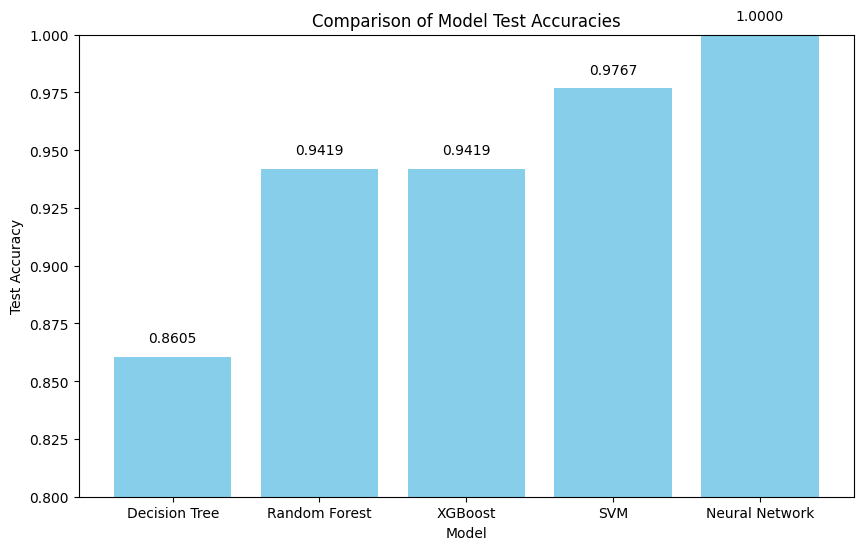

In [105]:
import matplotlib.pyplot as plt

# Example data
model_names = ['Decision Tree', 'Random Forest', 'XGBoost', 'SVM', 'Neural Network']
accuracies = [accuracy_tree, accuracy_forest, accuracy_xgb, accuracy_svm, accuracy_nn]

plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(model_names, accuracies, color='skyblue')

# Add title and labels
plt.title('Comparison of Model Test Accuracies')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')

# add the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.005, f'{accuracy:.4f}', ha='center', va='bottom')

plt.ylim(0.8, 1)
plt.show()
